In [1]:
! pip install votekit

# Proportionality and Model Validation

This notebook is intended to teach you about some ways to visualize and measure proportionality. It will also touch on model validation. It should be noted that these are both highly active research areas, so these are works in progress.

# Measures of Proportionality

One way to measure proportionality is via a score we call "disproportionality". You can compute this signed or unsigned. The signed version is simply `S-C`, while the unsigned version is `|S-C|`, where `S` is seat share and `C` is your favorite measure of support.

You can then take the average of this over a set of elections to score your favorite election mechanism.

Below, we use the same set of Scottish elections to measure the disproportionality of STV and Borda. Our measure of support `C` is the share of first place votes for SNP and Green party candidates.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from functools import partial
from matplotlib.lines import Line2D 
from pathlib import Path
import math
from tqdm.notebook import tqdm
from glob import glob
from votekit.cvr_loaders import load_scottish
from votekit.utils import first_place_votes
from votekit.elections import STV, Borda

SCOT_ELEX_PATH = "/Users/cdonnay/PycharmProjects/scot-elex"
b_bloc_parties = ["Scottish National Party (SNP)", "Green (Gr)"]
b_bloc_label = "SNP and Green"
bloc_order = "AB"
stv_color = "#1560BD"
borda_color = "#FB607F"

In [ ]:
all_files = glob(f"{SCOT_ELEX_PATH}/*_cands/*.csv")

data_stv = []
data_borda = []


for file_name in tqdm(all_files):
    profile, num_seats, cand_list, cand_to_party, ward_name = load_scottish(file_name)
    cand_to_bloc = {c:"B" if cand_to_party[c] in b_bloc_parties 
                else "A" for c in cand_list}

    bloc_to_cand_num = {"A": len([c for c, bloc in cand_to_bloc.items() if bloc == "A"]),
                    "B": len([c for c, bloc in cand_to_bloc.items() if bloc == "B"])}

    

    fpv_dict = first_place_votes(profile)

    total_fpv = sum(fpv_dict.values())
    fpv_b_bloc = sum([v for c,v in fpv_dict.items() if cand_to_bloc[c] == "B"])
    fpv_b_share = fpv_b_bloc/total_fpv

    if bloc_to_cand_num["B"] < math.floor(fpv_b_share*num_seats) or bloc_to_cand_num["B"] == 0:
        continue 


    stv_election  = STV(profile, m = num_seats)
    stv_winners= [c for s in stv_election.get_elected() for c in s]
    stv_num_B_winners = len([c for c in stv_winners if cand_to_bloc[c] == "B"])
    stv_b_seat_share = stv_num_B_winners/num_seats
    data_stv.append((fpv_b_share, stv_b_seat_share))

    borda_election  = Borda(profile, m = num_seats, tiebreak="first_place")
    borda_winners= [c for s in borda_election.get_elected() for c in s]
    borda_num_B_winners = len([c for c in borda_winners if cand_to_bloc[c] == "B"])
    borda_b_seat_share = borda_num_B_winners/num_seats
    data_borda.append((fpv_b_share, borda_b_seat_share))


stv_avg_sc = sum(y-x for (x,y) in data_stv)/len(data_stv)
stv_avg_abs_sc = sum(abs(y-x) for (x,y) in data_stv)/len(data_stv)
print(f"STV Average S-C {stv_avg_sc:.2f}")
print(f"STV Average |S-C| {stv_avg_abs_sc:.2f}")

borda_avg_sc = sum(y-x for (x,y) in data_borda)/len(data_borda)
borda_avg_abs_sc = sum(abs(y-x) for (x,y) in data_borda)/len(data_borda)
print()
print(f"Borda Average S-C {borda_avg_sc:.2f}")
print(f"Borda Average |S-C| {borda_avg_abs_sc:.2f}")


This many elections do not have either B bloc party: 0

STV Average S-C 0.02
STV Average |S-C| 0.08
borda Average S-C 0.02
borda Average |S-C| 0.12


Another way to view the proportional tendencies of a system of election is to plot a measure of "support" for a slate of candidates against the seat share of that slate. The closer this is to the line `y=x`, the closer we might consider the system to being proportional with respect to your measure.

We call this a waterfall plot!

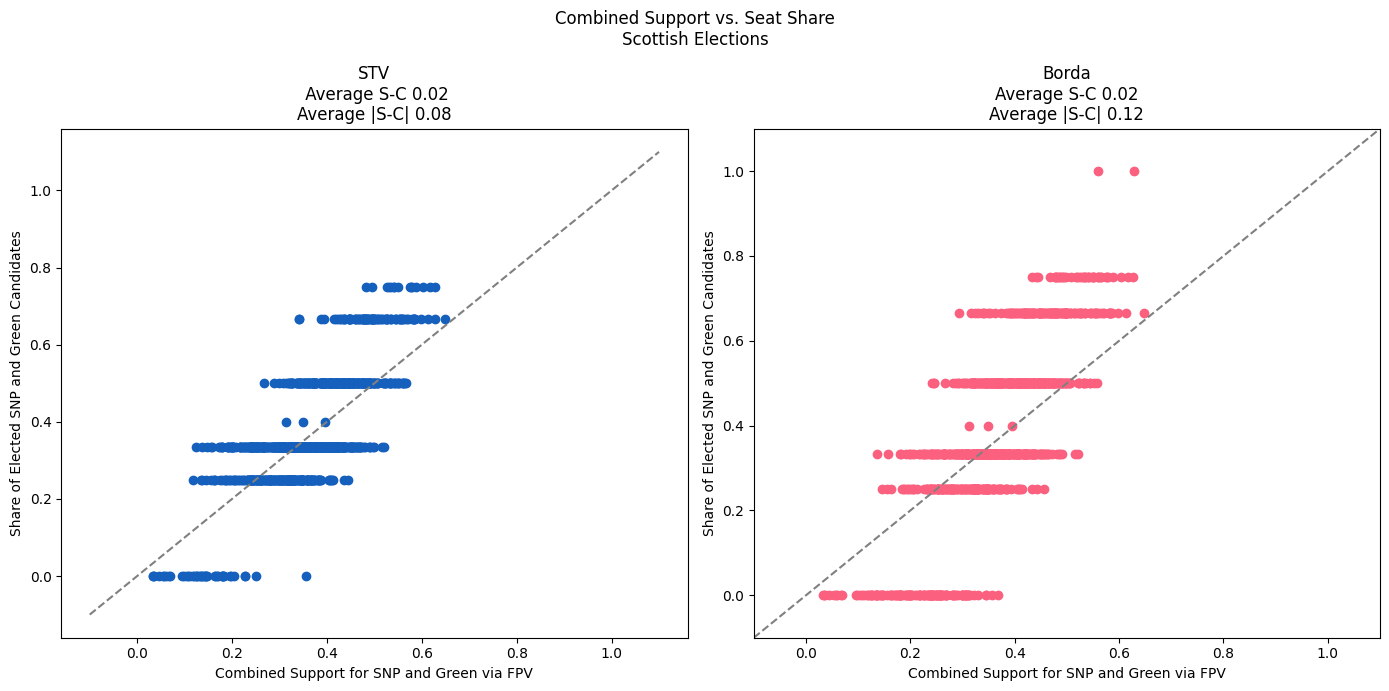

In [14]:
fig, axs = plt.subplots(1,2, figsize=(14,7))
prop_line = np.linspace(-.1,1.1, 100)


axs[0].plot(prop_line, prop_line, label= "Proportionality", color="gray", ls= "dashed")
axs[0].set_ylabel(f'Share of Elected {b_bloc_label} Candidates')
axs[0].set_xlabel(f'Combined Support for {b_bloc_label} via FPV')  
axs[0].scatter([x for x,y in data_stv], [y for x,y in data_stv],color =stv_color , label = "STV")
axs[0].set_title(f"STV\n Average S-C {stv_avg_sc:.2f}\nAverage |S-C| {stv_avg_abs_sc:.2f}")


axs[1].plot(prop_line, prop_line, label= "Proportionality", color="gray", ls= "dashed")
axs[1].set_ylabel(f'Share of Elected {b_bloc_label} Candidates')
axs[1].set_xlabel(f'Combined Support for {b_bloc_label} via FPV')  
axs[1].scatter([x for x,y in data_borda], [y for x,y in data_borda],color =borda_color , label = "Borda")
axs[1].set_title(f"Borda\nAverage S-C {borda_avg_sc:.2f}\nAverage |S-C| {borda_avg_abs_sc:.2f}")

plt.ylim(-.1, 1.1)
plt.xlim(-.1, 1.1)
plt.suptitle(f"Combined Support vs. Seat Share\nScottish Elections")
plt.tight_layout()


Here is an example comparing Borda to STV generated from a parameter sweep of a few ballot generators from a [recent preprint of ours](https://mggg.org/prvtp). Replication code can be found in [this repo.](https://github.com/mggg/PRVTP/tree/main)

<p float="left">
  <img src="../../data/PAPER_WITH_STRENGTH_5_seats_combined_support_Borda.png" width="400" />
  <img src="../../data/PAPER_WITH_STRENGTH_5_seats_combined_support_STV.png" width="400" />
</p>

# Model Validation

Model validation is too intensive to be run live. If you want example code, please see [our repo](https://github.com/mggg/PRVTP/tree/main/Scottish/minimize_l1) for the paper mentioned above.

Here is an example of trying to fit our models to Scottish data. We set two blocks of voters, then ran a grid search over the parameter space for cohesion and bloc proportion to try and minimize the total variaton distance from the sampled distribution to the observed election. For more details, see the paper above.

<p float="left">
  <img src="../../data/HIGHLIGHT_aberdeen ward_12 2017_swap_distance_bubble_plots.png" width="400" />
  <img src="../../data/HIGHLIGHT_falkirk ward_6 2017_swap_distance_bubble_plots.png" width="400" />
</p>